In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time, traceback
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50, InceptionResNetV2, DenseNet201

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy, categorical_crossentropy

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data')).replace('\\', '/') + '/'
MODEL_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'model')).replace('\\', '/') + '/'

# DeepFashion: Versión reducida

En este notebook se realiza la comparativa entre un modelo multietiqueta formado por un único clasificador y un modelo compuesto por un clasificador por tipo de atributo. 

Se emplea la versión reducida del conjunto de datos de DeepFashion. En análisis descriptivo de este conjunto de datos se realiza en un [Notebook anexo](./DeepFashion_VersionReducida_Analisis.ipynb). También se ha realizado [el mismo análisis](./DeepFashion_VersionCompleta_Analisis.ipynb) de la versión completa del dataset.

Para el particionado de datos en los conjuntos de entrenamiento, validación y test se emplean las particiones proporcionadas junto con el conjunto de datos. En el análisis mencionado anteriormente se ha podido comprobar que la proporción de cada uno de los atributos es similar en las tres particiones. 

El principal problema de este conjunto es el _data imbalance_. Dentro de cualquiera de los seis tipos de atributo ((Estampado, tipo de manga, forma, tipo de cuello, tejido y tallaje) existen atributos que aparecen con mucha más frecuencia que otros. Por ejemplo, en la partición de test y dentro de los tipos de tejido, _cotton_ aparece 2736 veces mientras que _faux_ aparece únicamente 46 por lo que será muy difícil que los modelos aprendan características de este atributo. 

In [3]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

En primer lugar se crea una serie de estructuras de datos auxiliares para facilitar el trabajo con el dataset entre las que se incluye:
* __column_to_attr_name__: Mapping de número de columna a nombre de atributo 
* __attr_type_to_columns__: Mapping del tipo de atributo hacia las columnas que pertenecen a atributos de ese tipo.
* __attributes__: Listado de atributos en el orden en el que aparecen en el conjunto de datos.

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

In [5]:
# column_to_attr_name: Mapping número columna -> Nombre de atributo
# attr_type_to_columns: Mapping tipo de atributo - Lista de columnas de atributos de dicho tipo
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
# Listado con los nombre de los atributos
attributes = list(column_to_attr_name.values())

Copiamos los datos a una estructura de directorios con la que sea sencillo trabajar. Extraemos las imágenes que forman parte de cada una de las paticiones, y las copiamos en un directorio con el nombre de la partición (test, val, train):

In [6]:
# Devuelve el listado de imágnes del fichero recibido como parámetro
def read_image_list(file_name):
    file_path = ANNO_FINE_PATH + '/' + file_name + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
# Devuelve el path de la partición a partir del nombre de la partición
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

# Creación de la estructura de datos necesaria para los generadores de aumentación de datos
def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            # Carga del listado de imágenes
            image_list = read_image_list(partition)
            # Copia
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [7]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes que realizan las transformaciones de data augmentation de forma dinámica a la hora de realizar el entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [8]:
# Construcción del dataframe requerido para usar la función flow_from_dataframe
# En el caso de no pasarle attr_type, tiene en cuenta todos los atributos (empleado en la versión con un único modelo)
# En caso contrario, filtra los atributos pertenecientes al tipo pasado por parámetro. (empleado en la versión de un modelo por
# tipo de atributo)
def build_iterator_dataframe(partition, attr_type=None):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
    # Filtrado por tipo de atributo. Empleado para los clasificadores separados por tipo de atributo. 
    if attr_type is not None:
        columns = attr_type_to_columns[str(attr_type)]
        fst, lst = columns[0], columns[-1]+1
        data = data.iloc[:, fst:lst]
    
    if 'filename' not in data.columns:
        data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [9]:
# Devuelve los nombres de los atributos pertenecientes al tipo de atributo pasado por parámetro
def get_attributes_for_attribute_type(attr_type):
    if attr_type is None:
        return attributes
    else:
        return [column_to_attr_name[c] for c in attr_type_to_columns[str(attr_type)]]

In [10]:
SEED = 1
BATCH_SIZE = 4


# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode, attr_type = None):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224, attr_type = None):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test', attr_type),
        x_col="filename",
        y_col=get_attributes_for_attribute_type(attr_type),        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

Para validar visualmente las transformaciones realizadas, el siguiente código elige de forma aleatoria una imagen de la partición de test y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

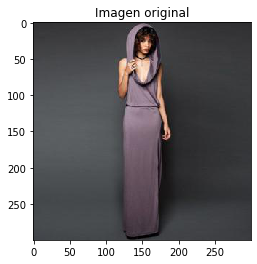

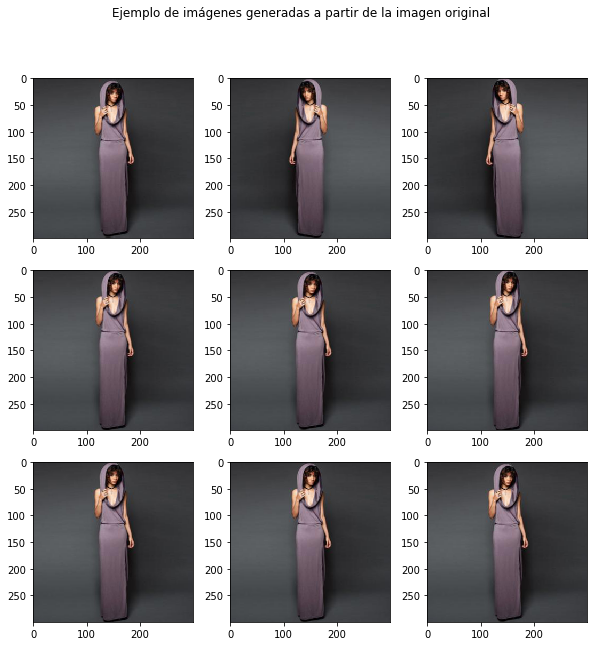

In [11]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Dado que se va a realizar el entrenamiento de un gran número de modelos y el tiempo para la realización del proyecto es limitado, se realiza una automatización de todo el proceso para poder probar distintos modelos de forma flexible, y minimizando el tiempo de interacción con el notebook para realizar el entrenamiento, y así maximizar el aprovechamiento del tiempo disponible. 

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo. Incluye un tercer parámetro (attr_type), obligatorio en los casos en los que se quiera hacer el entrenamiento de un modelo para un tipo de atributo en particular. Este campo toma valores del 1 al 6, basado en la constante ATTR_TYPES.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 

Por otro lado, toma como parámetro la función de loss a emplear, y *model_build_params*, un diccionario con el que se le puede pasar valores de parámetros a las funciones de construcción de modelos. 

Finalmente, se definen también los parámetros de data augmentation, configurados con los valores por defecto con los que se consiguen los mejores resultados (ver apartado 4.2).

In [12]:
# Definición de la función de loss ponderada. 
# Detallado en la sección "Selección de función de loss"

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [13]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id, attr_type = None):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    if attr_type is None:
        return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)
    else:
        return '{}/{}_{}_{}.h5'.format(MODEL_PATH, model_name, model_id, attr_type)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model

def build_callbacks(model_name, model_id, store_model, attr_type):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id, attr_type), 
                                     monitor='val_auc', verbose=1, save_best_only=True, mode='max')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=binary_crossentropy,
          attr_type=None,
          class_weight = None
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode, attr_type)
    
    
    
    # FIT
    # Basado en el parámetro two_step_fit, se permite un único entrenamiento, o un entrenamiento en dos fases: una primera fase
    # en la que se ajusta primero las últimas capas densas, y un segundo paso en el que se ajusta el resto de capas no congeladas.
    # En el caso de emplear el entrenamiento en dos fases, la función build ha de congelar todas las capas exceptuando las densas
    # de la parte final de la red.
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10,
                                class_weight=class_weight
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model, attr_type),
                                steps_per_epoch=50,
                                validation_steps=10,
                                class_weight=class_weight
                               )
    
    return (h.history['val_loss'], h.history['val_accuracy'], h.history['val_auc'])

El siguiente fragmento de código automatiza la creación y entrenamiento de varias versiones de un mismo modelo y devuelve un Dataframe con los resultados. 

La búsqueda de los parámetros se realiza de forma aleatoria. Los parámetros variables son:
* Tipo de pooling (max, avg, sin pooling)
* Tamaño de la capa densa final
* Porcentaje de capas que se mantienen congeladas (es decir, que se mantienen con los valores iniciales sin reentrenar). 

El entrenamiento se realiza en dos pasos:
1. Se congelan todas las capas del modelo pre-entrenado para entrenar únicamente las capas densas añadidas en la parte final de la red.
2. Se descongela un porcentaje de las últimas capas del modelo pre-entrenado y se repite el entrenamiento.

Todos los modelos entrenados se persisten junto a un ID para poder ser recuperados posteriormente en el apartado de evaluación. 

In [14]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"
ACTIVATION_FUNCTION = "activation_function"
OUTPUT_LAYER_SIZE = "output_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name, 
                         attr_type=None, 
                         activation_function = 'sigmoid', 
                         loss_function = binary_crossentropy,
                         output_layer_size = NUM_CLASSES):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss', 'val_acc', 'val_auc', 'time'])
    for i in range(0, N):
        try:
            # Random search de los parámetros
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            
            # Definición de la función de activación para usar en la capa de salida
            params[ACTIVATION_FUNCTION] = activation_function
            params[OUTPUT_LAYER_SIZE] = output_layer_size
            
            print('Evaluation #{}'.format(i))
            start = time.time()
            
            # Llamada a la función de entrenamiento definida en apartados anteriores
            (val_loss,  val_acc, val_auc) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, 
                                        attr_type=attr_type, loss_function=loss_function)
            end = time.time() - start
            
            # Acumulación de los resultados
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_acc, val_auc, end]
        except Exception as e:
            traceback.print_exc()
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

In [15]:
# Utilidad para mostrar métricas
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        plt.plot(v)
        legend.append(k)
    plt.title('Comparativa de ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [16]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación y se emplean imágenes de tamaño 224x224.

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [17]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_accuracy', 'val_auc'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_acc, val_auc) = train('baseline', it, store_model=False,
                                             shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                             fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_acc), max(val_auc)]
    return results

In [18]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 36 days, 21:15:03.878990


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.05,0.15,2.50,constant,0.35,0.50
11,0.05,0.10,5,wrap,0.35,0.47
13,0.03,0.05,2.50,wrap,0.35,0.44
1,0.10,0.15,2.50,constant,0.35,0.39
18,0.10,0.10,7.50,constant,0.35,0.45
17,0.10,0.15,7.50,nearest,0.35,0.48
7,0.05,0.03,5,nearest,0.35,0.50
20,0.10,0.05,7.50,constant,0.35,0.38
23,0.10,0.05,5,constant,0.35,0.48
24,0.05,0.15,7.50,constant,0.35,0.52


Se establece los valores que minimizan el valor de loss y maximizan el accuracy sobre el conjunto de validación como los valores por defecto a emplear en la aumentación de datos, y serán los que se usarán para el entrenamiento de los modelos de los siguientes apartados. 

### 4.3 Selección de métricas y función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que, en el caso de clasificadores multietiqueta, esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones, tal y como se comenta en [aquí](https://stackoverflow.com/questions/50686217/keras-how-is-accuracy-calculated-for-multi-label-classification). En el caso de este dataset existen 26 clases, y cada observación está asociada a 6 valores positivos y a 20 negativos. Este alto número de valores negativos hace que se obtenga siempre un valor alto de accuracy, por lo que, para la versión de un único clasificador para todos los tipos de atributo, se ha optado por emplear el área bajo la curva ROC (AUC). Se considera que esta métrica, al estar basada en la relación entre sensitividad y especificidadad, se ajusta más al problema en cuestión. 

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu). El código se ha definido en el apartado anterior. 

Esto aplica a la versión de un único clasificador para todos los tipos de datos. Para la versión de un clasificador por tipo de dato, la versión reducida del conjunto de datos asegura que siempre habrá un único atributo de cada tipo que aplique, lo que lo convierte en un problema de clasificación categórica y se empleará la función de loss *categorical_crossentropy* y el accuracy para comparar los modelos entre sí. En la versión completa del dataset, una imagen puede estar etiquetada con varios atributos de cada tipo (o ninguno), por lo que se empleará la misma estrategia que con el clasificador único. 

Finalmente, para establecer la comparativa entre los modelos se empleará las métricas de *recall*, *precision* y F1, calculado sobre los top-k atributos (k atributos con mayor probabilidad en la predicción del modelo). Para este dataset se empleará k=6, puesto que a partir del análisis de datos sabemos a priori que todas las observaciones tienen 6 atributos con valor positivo. Cuando se realice la comparativa con los modelos estado del arte a partir del entrenamiento de los modelos con el dataset completo, donde no existe un número fijo de atributos positivos por observación, se empleará k=3 y k=5 como en la literatura de referencia. 

Las métricas de *recall*, *precision* y F1 se calcularán en dos variantes: con *micro-average* y *macro-average*, como se explica en [este artículo](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin). La primera realiza la media a partir de la precisión y la exhaustividad global por lo que sirve como estimador del rendimiento global del modelo, mientras que la segunda realiza la media de F1 de todos los atributos, por lo que el peso de atributos mayoritarios y minoritarios es el mismo y sirve como un estimador más robusto en casos con datos no balanceados como los empleados en este trabajo, donde interesa que el modelo sea capaz de predecir tanto los atributos mayoritarios como los minoritarios. 

Vamos a realizar la prueba para comprobar las dos funciones de loss mencionadas anteriomente. Se entrena el modelo baseline empleando las las funciones de loss *binary_crossentropy* y *weighted_binary_crossentropy* y se establece la comparativa.

In [19]:
RESET = False
if(RESET):
    %cache -r res_binary_crossentropy
    %cache -r res_weighed_crossentropy

%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy, store_model=False)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy, store_model=False)

Loading cached value for variable 'res_binary_crossentropy'. Time since caching: 19 days, 0:51:38.223564
Loading cached value for variable 'res_weighed_crossentropy'. Time since caching: 19 days, 0:44:52.479359


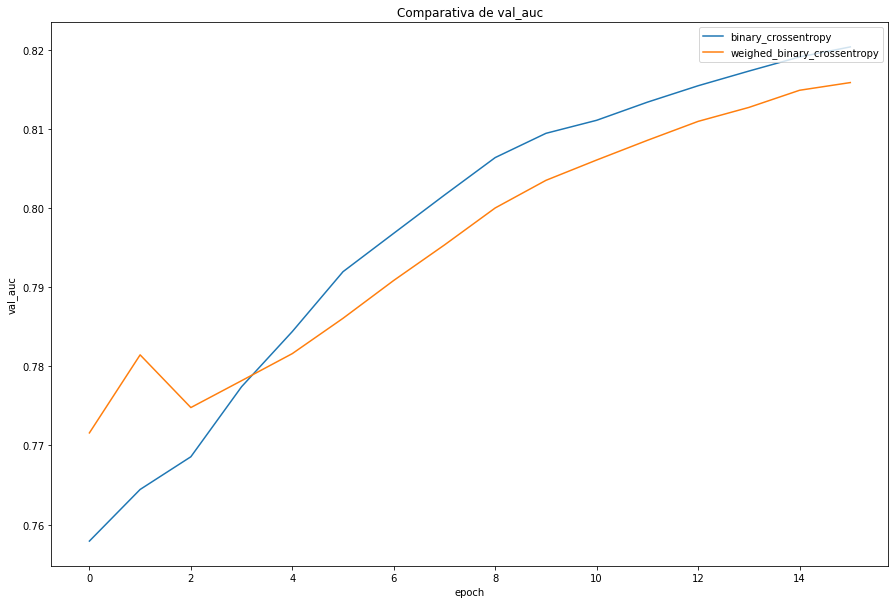

Max. val_auc binary_crossentropy: 0.820396900177002
Max. val_auc weighed_binary_crossentropy:0.8158870935440063


In [20]:
results = {'binary_crossentropy' : res_binary_crossentropy[2], 'weighed_binary_crossentropy' : res_weighed_crossentropy[2]}
plot(results, metric='val_auc')

print('Max. val_auc binary_crossentropy: {}'.format(max(res_binary_crossentropy[2])))
print('Max. val_auc weighed_binary_crossentropy:{}'.format(max(res_weighed_crossentropy[2])))

A partir de la gráfica anterior se puede comprobar que se obtienen valores superiores con la función loss de *binary crossentropy*, por lo que se empleará esta función de loss, y no la versión ponderada. 

## 5. Arquitecturas pre-entrenadas

En este apartado se definen las funciones de construcción de los modelos que emplea la función **train** definida anteriormente. Se basa en arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten inicializar los valores a pesos entrenandos sobre ImageNet, por lo que permite beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

Se ha optado por realizar las pruebas con **InceptionV3**, **ResNet50**, **VGG16**, **InceptionResNetV2** y **DenseNet201**.

In [21]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_InceptionResNetV2(input_shape, params):
    base_model = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_DenseNet201(input_shape, params):
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(params[OUTPUT_LAYER_SIZE], activation=params[ACTIVATION_FUNCTION])(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


# 6. Versión 1: Un único clasificador

## 6.1 Entrenamiento

En este apartado se realizará el entrenamiento y evaluación de la versión con un único clasificador para todos los tipos de atributos. 

Cabe destacar que para este tipo de clasificador se empleará la función loss *binary_crossentropy* tal y como se ha comentado en el apartado 4.3 y la función de activación sigmoide para poder permitir la clasificación multi etiqueta. 

La selección de la mejor versión del modelo para cada una de las arquitecturas probadas se realizará en base a los valores de loss y AUC sobre los datos de validación. 

Lanzamos la búsqueda:

In [22]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16
    %cache -r results_inceptionResNetV2
    %cache -r results_densenet201    

%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')
%cache results_inceptionResNetV2 = try_pretrained_model('InceptionResNetV2')
%cache results_densenet201 = try_pretrained_model('DenseNet201')

Loading cached value for variable 'results_inceptionV3'. Time since caching: 20 days, 20:26:15.260364
Loading cached value for variable 'results_resnet50'. Time since caching: 20 days, 17:37:47.562860
Loading cached value for variable 'results_vgg16'. Time since caching: 20 days, 14:35:01.156261
Loading cached value for variable 'results_inceptionResNetV2'. Time since caching: 20 days, 8:19:14.149826
Loading cached value for variable 'results_densenet201'. Time since caching: 20 days, 0:58:52.787701


Definimos una función para ordenar los modelos generados en función del valor mínimo de loss sobre el conjunto de validación. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [23]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["max_val_auc"] = df.apply(lambda row: max(row['val_auc']), axis=1)
 #   df["max_val_acc"] = df.apply(lambda row: max(row['val_acc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc'])
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura __InceptionV3__:

In [24]:
results_inceptionV3 = sort_by_max_accuracy(results_inceptionV3)
results_inceptionV3

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
24,avg,368,0.80,"[0.8524038195610046, 0.8393028378486633, 0.846...",469.36,0.25,0.89
6,avg,408,0.70,"[0.8123798370361328, 0.8478364944458008, 0.833...",579.84,0.25,0.88
14,avg,152,0.60,"[0.802884578704834, 0.8340144157409668, 0.8331...",499.28,0.25,0.88
17,max,360,0.80,"[0.8150240182876587, 0.8316105604171753, 0.810...",362.60,0.25,0.87
13,avg,168,0.80,"[0.8544471859931946, 0.8236778974533081, 0.844...",353.40,0.26,0.88


Mostramos los resultados obtenidos para la arquitectura __ResNet50__:

In [25]:
results_resnet50 = sort_by_max_accuracy(results_resnet50)
results_resnet50

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
11,avg,424,0.50,"[0.8084133863449097, 0.8141826391220093, 0.807...",540.33,0.37,0.84
10,None,168,0.50,"[0.8187500238418579, 0.8216346502304077, 0.824...",553.66,0.38,0.81
22,None,256,0.50,"[0.8228365182876587, 0.8247596621513367, 0.812...",472.41,0.38,0.82
13,None,296,0.80,"[0.8170673251152039, 0.8177884221076965, 0.820...",405.56,0.38,0.80
17,None,312,0.70,"[0.6955528855323792, 0.814302921295166, 0.8210...",454.86,0.38,0.78


Mostramos los resultados obtenidos para la arquitectura __VGG16__:

In [26]:
results_vgg16 = sort_by_max_accuracy(results_vgg16)
results_vgg16

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
18,max,496,0.80,"[0.8401442766189575, 0.8512018918991089, 0.850...",429.04,0.22,0.92
22,max,208,0.80,"[0.8235577344894409, 0.8490384221076965, 0.858...",537.08,0.22,0.91
17,None,344,0.80,"[0.8481971025466919, 0.8449519276618958, 0.852...",475.24,0.23,0.91
3,max,256,0.80,"[0.8200721740722656, 0.8485577702522278, 0.858...",532.97,0.24,0.91
9,None,488,0.80,"[0.8465144038200378, 0.8550480604171753, 0.864...",317.44,0.24,0.91


Mostramos los resultados obtenidos para la arquitectura __InceptionResNetV2__:

In [27]:
results_inceptionResNetV2 = sort_by_max_accuracy(results_inceptionResNetV2)
results_inceptionResNetV2

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
0,avg,368,0.50,"[0.8129808306694031, 0.778245210647583, 0.7967...","1,134.28",0.28,0.87
12,max,360,0.70,"[0.7731971144676208, 0.7876201868057251, 0.771...","1,426.93",0.28,0.87
17,avg,200,0.60,"[0.792067289352417, 0.7769231200218201, 0.8264...",930.98,0.31,0.87
16,None,216,0.70,"[0.7926682233810425, 0.8195914030075073, 0.801...","1,013.13",0.31,0.84
9,avg,208,0.60,"[0.7379807233810425, 0.7817307710647583, 0.784...",929.84,0.31,0.84


Mostramos los resultados obtenidos para la arquitectura __Densenet201__:

In [28]:
results_densenet201 = sort_by_max_accuracy(results_densenet201)
results_densenet201

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_acc,time,min_val_loss,max_val_auc
15,avg,416,0.50,"[0.8205528259277344, 0.7536057829856873, 0.811...","1,477.38",0.23,0.88
11,avg,480,0.50,"[0.8187500238418579, 0.8246394991874695, 0.852...","1,026.57",0.24,0.88
18,avg,344,0.60,"[0.7665865421295166, 0.8268029093742371, 0.828...","1,018.73",0.24,0.89
24,avg,344,0.70,"[0.7796875238418579, 0.8469951748847961, 0.870...",761.44,0.24,0.90
3,avg,312,0.60,"[0.7536057233810425, 0.8200721740722656, 0.851...","1,018.79",0.24,0.89


## 6.2 Evaluación

En este apartado se realizará la evaluación de las versiones de cada una de las arquitecturas probadas en el apartado anterior con el que se han obtenido mejores resultados. Se empleará aquellas versiones que minimizan el loss sobre el conjunto de validación. 

Tal y como se ha comentado en la sección de [seleccion de métricas](./DeepFashion_VersionReducida.ipynb#4.3-Selecci%C3%B3n-de-m%C3%A9tricas-y-funci%C3%B3n-de-loss), se calculará los valores de *precision*, *recall* y F1 sobre sobre las k=6 etiquetas con mayor probabilidad en la respuesta del modelo. Estas métricas se basan en las mencionadas en 
[Deep Convolutional Ranking for Multilabel Image Annotation](https://arxiv.org/abs/1312.4894)- apartado 4.2 para establecer una comparativa entre modelos multilabel. 

In [29]:
KS =  [3,5,6]

# Calcula
## Número de veces que aparece un atributo en una predicción
## Número de veces en el que la predicción de un atributo se realiza de forma correcta
## Número de veces en el que la predicción de un atributo se realiza de forma incorrecta
def get_prediction_metrics(y_true_df, y_pred, k=6):
    
    # Inicialización de los vectores
    times_predicted = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
    times_correctly_predicted = [0] * NUM_CLASSES
    times_incorrectly_predicted = [0] * NUM_CLASSES

    for index, row in y_true_df.iterrows():
        
        # Obtención de los verdaderos positivos
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1

        # Obtención de los k valores con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            
            # Clasificación
            times_predicted[p]+=1
            if p in true_possitives[0]:
                times_correctly_predicted[p]+=1
            else:
                times_incorrectly_predicted[p]+=1
    return times_predicted, ground_truth, times_correctly_predicted, times_incorrectly_predicted

# Calcula recall, precision y f1 usando macro averaging
def compute_macro_average_metrics(times_predicted, ground_truth, tp, fp):
    m = {}
    recall_per_label = [a/b for a,b in zip(tp,ground_truth)]
    precision_per_label = [a/max(1,b) for a,b in zip(tp,times_predicted)]
    m['recall'] =  sum(recall_per_label)/NUM_CLASSES
    m['precision'] = sum(precision_per_label)/NUM_CLASSES
    f1_per_label = [2 * (p * r) / max(1,(p + r)) for p,r in zip(precision_per_label, recall_per_label)]
    m['f1'] = sum(f1_per_label)/NUM_CLASSES
    return m

# Calcula recall, precision y f1 usando micro averaging
def compute_micro_average_metrics(times_predicted, ground_truth, tp, fp):
    m = {}
    m['recall'] = sum(tp)/sum(ground_truth)
    m['precision'] = sum(tp)/sum(times_predicted)
    m['f1'] = 2 * (m['precision'] * m['recall']) / max(1,(m['precision'] + m['recall']))
    return m

# Calcula recall, precision y f1 usando micro/macro averaging para las k etiquetas con mayor probabilidad
def compute_evaluation_results(y_true_df, y_pred):
    results = {}
    for k in KS:
        # Calculo métricas de clasificación
        times_predicted, ground_truth, tp, fp = get_prediction_metrics(y_true_df, y_pred, k)
        
        results_k = {}
        results[k] = results_k
        # Micro average
        results_k['micro'] = compute_micro_average_metrics(times_predicted, ground_truth, tp, fp)
        
        # Macro average
        results_k['macro'] = compute_macro_average_metrics(times_predicted, ground_truth, tp, fp)
    return results

# Evaluación de un modelo.     
def evaluate(model_name, model_id):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
    
    # Generator de datos de test
    test_generator = build_test_generator()
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    # Calcula resultados en formato r[k][average type][metric] donde
    # k - numero de etiquetas con mayor probabilidad
    # average type - micro|macro
    # metric - precision|recall|f1
    results = compute_evaluation_results(y_true_df, y_pred)
        
    return (y_pred, results)

Recuperamos el ID para cada uno de los modelos con el valor mínimo de loss sobre el conjunto de validación, y lanzamos la evaluación:

In [30]:
RESET = False
if(RESET):
    %cache -r inceptionV3_test_res
    %cache -r resnet50_test_res
    %cache -r vgg16_test_res 
    %cache -r inceptionResNetV2_test_res 
    %cache -r densenet201_test_res 
    
%cache inceptionV3_test_res = evaluate('InceptionV3', model_id = results_inceptionV3.iloc[0].name)
%cache resnet50_test_res = evaluate('ResNet50',model_id = results_resnet50.iloc[0].name)
%cache vgg16_test_res = evaluate('VGG16', model_id = results_vgg16.iloc[0].name)
%cache inceptionResNetV2_test_res = evaluate('InceptionResNetV2', model_id = results_inceptionResNetV2.iloc[0].name)
%cache densenet201_test_res = evaluate('DenseNet201', model_id = results_densenet201.iloc[0].name)

Loading cached value for variable 'inceptionV3_test_res'. Time since caching: 20 days, 0:58:05.379973
Loading cached value for variable 'resnet50_test_res'. Time since caching: 20 days, 0:56:56.385878
Loading cached value for variable 'vgg16_test_res'. Time since caching: 20 days, 0:56:08.878761
Loading cached value for variable 'inceptionResNetV2_test_res'. Time since caching: 20 days, 0:54:35.580271
Loading cached value for variable 'densenet201_test_res'. Time since caching: 20 days, 0:52:21.244055


In [31]:
COLUMNS = ['recall.micro','precision.micro','f1.micro','recall.macro','precision.macro','f1.macro']

def build_result_df(result_list, k):
    rows = []
    names = []
    for model_results, model_name in result_list:
        row = []
        rows.append(row)
        names.append(model_name)
        for avg in ['micro', 'macro']:
            for metric in ['recall', 'precision', 'f1']:
                row.append(model_results[k][avg][metric])

    return pd.DataFrame(rows, columns=COLUMNS, index=names)

In [32]:
result_list = [(inceptionV3_test_res[1], 'InceptionV3'),
               (resnet50_test_res[1], 'ResNet50'),
               (vgg16_test_res[1], 'VGG16'),
               (inceptionResNetV2_test_res[1], 'InceptionResNetV2'),
               (densenet201_test_res[1], 'DenseNet201')]


In [33]:
#build_result_df(result_list, k=3)
#build_result_df(result_list, k=5)
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
InceptionV3,0.73,0.73,0.73,0.42,0.47,0.41
ResNet50,0.60,0.60,0.60,0.23,0.14,0.17
VGG16,0.76,0.76,0.76,0.45,0.55,0.46
InceptionResNetV2,0.72,0.72,0.72,0.37,0.48,0.35
DenseNet201,0.76,0.76,0.76,0.45,0.52,0.44


# 6.3. Análisis de los resultados

En este apartado se realizará un análisis de los resultados del modelo con el que se han obtenido mejores resultados en el apartado anterior para k=6. 

Como se observa en la tabla del apartado anterior, el tipo de arquitectura con el que se obtiene un valor superior es VGG16 por lo que consideraremos éste como el mejor de los modelos probados, y con el que se realizará el análisis posterior. 

En primer lugar vamos a visualizar una muestra de imágenes junto con las etiquetas reales y las etiquetas predichas por el modelo. Para el conjunto de etiquetas predichas, se recupera las 6 etiquetas con mayor probabilidad según el modelo. Se emplea este valor puesto que se sabe a priori que el conjunto de etiquetas real está formado por 6 elementos en esta versión del dataset. 

Cuando se realice este procedimiento sobre el conjunto de datos completo en el que el número de etiquetas real es variable, se empleará k=3 y k=5 puesto que éstos son los valores empleados como benchmark. 

In [34]:
# Muestra N ejemplos de la partición de test con sus etiquetas reales y las etiquetas predichas
# Para las etiquetas predichas, recupera las k etiquetas con mayor probabilidad. 
def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        # Mostrar imagen
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        # Recuperar las etiquetas reales
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        # Recuperar las k etiquetas con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return  

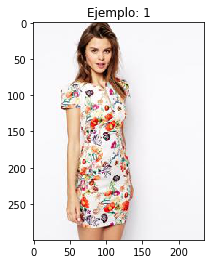

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


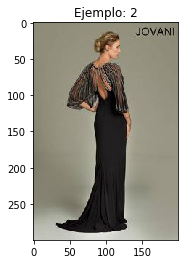

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['chiffon', 'conventional', 'cotton', 'crew_neckline', 'no_dress', 'solid']


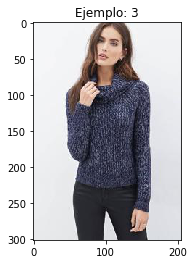

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress']


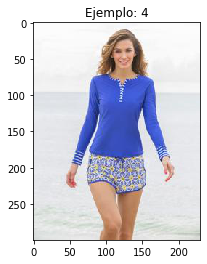

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


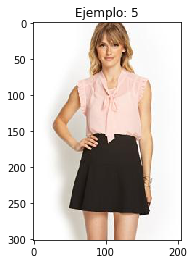

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'long_sleeve', 'mini_length', 'solid', 'v_neckline']


In [35]:
# Ejemplos para la red con mejores resultados en los apartados anteriores
y_pred_vgg16 = vgg16_test_res[0]
display_examples(y_pred_vgg16)

In [36]:
# Construcción de la tabla de resultados a partir de la lista de listas de valores predichos por un modelo sobre la partición de test
def build_results_table(y_pred):

    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columna de frecuencia de predicción, Verdaderos positivos y Falsos positivos
    times_predicted, ground_truth, times_correctly_predicted, times_incorrectly_predicted = get_prediction_metrics(y_true_df, y_pred)

    # Columnas de sensibilidad y precisión
    recall = [a/b for a,b in zip(times_correctly_predicted, ground_truth)]
    precision = [a/max(1,b) for a,b in zip(times_correctly_predicted, times_predicted)]
    f1 = [2 * (p * r) / max(1,(p + r)) for p,r in zip(precision, recall)]

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia real' : ground_truth, 
         'Frecuencia predicción' : times_predicted, 'TP': times_correctly_predicted, 'FP' : times_incorrectly_predicted, 
         'Recall' : recall, 'Precision' : precision, 'F1' : f1}
    return pd.DataFrame(data=d)


def build_results_table_by_attr_type(results):
    df = build_results_table(results).groupby('Tipo').mean()
    return df.drop(columns=['Frecuencia real', 'Frecuencia predicción', 'TP', 'FP'])

Mostramos también los resultados por cada atributo:

In [37]:
res_table_single = build_results_table(y_pred_vgg16)
res_table_single

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,700,442,258,0.67,0.63,0.65
1,graphic,Estampado,668,390,255,135,0.38,0.65,0.48
2,striped,Estampado,292,234,186,48,0.64,0.79,0.71
3,embroidered,Estampado,338,27,13,14,0.04,0.48,0.04
4,pleated,Estampado,78,4,1,3,0.01,0.25,0.01
5,solid,Estampado,1898,2185,1652,533,0.87,0.76,0.81
6,lattice,Estampado,62,0,0,0,0.00,0.00,0.00
7,long_sleeve,Tipo de manga,1243,1329,1046,283,0.84,0.79,0.81
8,short_sleeve,Tipo de manga,686,612,443,169,0.65,0.72,0.68
9,sleeveless,Tipo de manga,2071,2102,1827,275,0.88,0.87,0.88


In [38]:
res_per_attr_type_single = build_results_table_by_attr_type(y_pred_vgg16)
res_per_attr_type_single

,Recall,Precision,F1
Tipo,,,
Estampado,0.37,0.51,0.38
Forma,0.76,0.78,0.77
Tallaje,0.39,0.54,0.39
Tejido,0.24,0.41,0.23
Tipo de cuello,0.48,0.49,0.48
Tipo de manga,0.79,0.79,0.79


A partir de la tabla anterior se puede observar que la mayor problemática a la hora de entrenar el modelo ha sido el _data imbalace_. Los atributos que aparecen con mayor frecuencia (tanto en las particiones de entrenamiento y validación, como en la de test) suelen predecirse con mayor frecuencia que los atributos minoritarios. Esto implica que atributos como _leather_ o _faux_ no aparezcan en ninga predicción. Por otro lado llama la atención el bajo número de veces que el modelo predice atributos como _knit_ o _embroidered_. 

En una iteración posterior sobre estos modelos se podría contemplar aumentar el número de ejemplos de los atributos minoritarios en las particiones de entrenamiento y validación.

Por otro lado, en los casos en los que en una imagen aparecen varias prendas, se ha detectado que las anotaciones pertenecen a una de ellas mientras que el modelo parece predecir las de otra. Esto se puede apreciar en el ejemplo 4: la etiqueta real _floral_ aplica al pantalón corto mientras que el modelo predice _solid_ que aplica a la prenda superior. 

Finalmente, a partir de la tabla con los resultados por tipo de atributo, se aprecia que el modelo es capaz de reconocer con mayor precisión los atributos relativos a la forma de la prenda (*Forma*, *Tallaje*, *Tipo de cuello*, *Tipo de manga*) que al material con el que está elaborada (*Estampado*, *Tejido*). 

# 7. Versión 2: Un clasificador por tipo de atributo

Como se ha comentado en varias ocasiones, en la versión reducida de este conjunto de datos existe siempre un único atributo de cada tipo asociado a la imagen. Por ello, para la construcción de un clasificador por tipo de atributo se puede emplear la función de loss *categorical_crossentropy* así como la función de activación *softmax* para que cada uno de los clasificadores prediga siempre un único atributo. 

## 7.1 Entrenamiento

El entrenamiento se realiza empleando la misma metodología que con la versión anterior: por cada tipo de atributo se exploran 5 arquitecturas pre-entrenadas, y para cada una de estas arquitecturas se prueban 25 variantes con ciertos parámetros elegidos de forma aleatoria. 

In [39]:
def try_pretrained_models_per_attribute_type():
    res = {}
    for attr_type in range(1,3):
        output_layer_size = len(attr_type_to_columns[str(attr_type)])
        
        res_attr_type = {}
        res[attr_type] = res_attr_type
        for architecture in ['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']:
            print('$$$: Starting with attribute type {} and architecture {}'.format(attr_type, architecture))
            res_attr_type[architecture] = try_pretrained_model(architecture, attr_type, 
                                                               'softmax', categorical_crossentropy, output_layer_size)
    return res


In [40]:
# %cache -r results_split_per_attr_type
%cache results_split_per_attr_type = try_pretrained_models_per_attribute_type()

Warning! Expression has changed since last save, which was at 2020-11-15 22:05:50.241235
To store a new value, change the version ('-v' or '--version')  
Loading cached value for variable 'results_split_per_attr_type'. Time since caching: 27 days, 1:00:39.195901


Identificamos los mejores modelos probados por cada tipo de atributo y arquitectura probada:

In [41]:
# Devuelvel la mejor versión del modelo de entre las 25 probadas
def get_best_result(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["max_val_acc"] = df.apply(lambda row: max(row['val_acc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc', 'val_acc'])
    best_result = df.sort_values(by='min_val_loss', ascending=True).iloc[0]

    best_result_dict = best_result.to_dict()
    index = best_result.name
    best_result_dict['model_id'] = index
    return best_result_dict

# Devuelve una tabla con las mejores versiones probadas por cada tipo de atributo y arquitectura probada
def get_best_result_per_attribute_type(results):
    best_results_per_attribute_type = {}
    for attr_type in range(1,7):
        
        best_results = pd.DataFrame(columns = ['architecture','model_id', 'global_pooling_type',
                                          'dense_layer_size','freeze_layers_ratio',
                                          'time','min_val_loss', 'max_val_acc'])
        
        for i, architecture in enumerate(['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201']):
            best_result = get_best_result(results[attr_type][architecture])
            best_results.loc[i] = [architecture, 
                               best_result['model_id'],
                               best_result['global_pooling_type'],
                               best_result['dense_layer_size'],
                               best_result['freeze_layers_ratio'],
                               best_result['time'],
                               best_result['min_val_loss'],
                               best_result['max_val_acc']]
            
            
        best_results_per_attribute_type[attr_type] = best_results
    return best_results_per_attribute_type


In [42]:
r = get_best_result_per_attribute_type(results_split_per_attr_type)

Mejores modelos para el tipo de atributo **Estampado**:

In [43]:
r[1]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,15,avg,184,0.70,453.88,0.44,0.71
1,ResNet50,8,max,200,0.70,273.52,1.11,0.54
2,VGG16,0,max,344,0.80,260.87,0.56,0.73
3,InceptionResNetV2,13,max,432,0.80,833.44,1.00,0.57
4,DenseNet201,11,max,432,0.80,797.16,0.61,0.71


Mejores modelos para el tipo de atributo **Tipo de manga**:

In [44]:
r[2]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,18,avg,416,0.70,577.07,0.18,0.88
1,ResNet50,13,max,272,0.50,536.17,0.86,0.57
2,VGG16,8,avg,200,0.80,515.76,0.27,0.85
3,InceptionResNetV2,6,avg,296,0.50,"1,024.42",0.43,0.83
4,DenseNet201,16,avg,312,0.50,"1,056.32",0.07,0.90


Mejores modelos para el tipo de atributo **Forma**:

In [45]:
r[3]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,16,max,472,0.80,416.48,0.16,0.87
1,ResNet50,1,max,304,0.60,349.99,0.53,0.74
2,VGG16,14,max,240,0.80,358.41,0.17,0.89
3,InceptionResNetV2,10,None,192,0.70,"1,199.24",0.37,0.76
4,DenseNet201,2,None,184,0.80,888.64,0.18,0.84


Mejores modelos para el tipo de atributo **Tipo de cuello**:

In [46]:
r[4]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,9,avg,256,0.70,339.33,0.54,0.70
1,ResNet50,13,avg,336,0.60,534.81,0.90,0.46
2,VGG16,4,None,312,0.80,347.86,0.52,0.68
3,InceptionResNetV2,15,avg,320,0.50,"1,674.90",0.84,0.47
4,DenseNet201,12,avg,304,0.70,857.08,0.45,0.77


Mejores modelos para el tipo de atributo **Tejido**:

In [47]:
r[5]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,2,None,488,0.70,571.42,0.50,0.74
1,ResNet50,0,None,176,0.60,384.22,0.53,0.74
2,VGG16,9,avg,304,0.60,236.89,0.53,0.74
3,InceptionResNetV2,16,avg,464,0.70,486.31,0.56,0.74
4,DenseNet201,0,max,136,0.50,667.64,0.44,0.74


Mejores modelos para el tipo de atributo **Tallaje**:

In [48]:
r[6]

,architecture,model_id,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss,max_val_acc
0,InceptionV3,7,avg,288,0.70,290.85,0.04,0.84
1,ResNet50,19,None,280,0.50,493.76,0.14,0.84
2,VGG16,18,max,368,0.60,313.56,0.18,0.84
3,InceptionResNetV2,18,None,280,0.50,714.78,0.14,0.84
4,DenseNet201,7,max,344,0.80,"1,011.12",0.23,0.88


## 7.2 Evaluación

A continuación seleccionamos la mejor versión para cada uno de los tipos de atributo para realizar una prueba conjunta sobre los datos de test. 

In [49]:
best_models = [[1, 'VGG16', 0],
              [2, 'DenseNet201', 16],
              [3, 'VGG16', 14],
              [4, 'DenseNet201', 12],
              [5, 'DenseNet201', 0],
              [6, 'DenseNet201', 7]]

In [50]:
# Junta los resultados. Convierte, por ejemplo tres listas de tamaño [4000][7] y [4000][3] y [4000][2] en 
# una única lista de tamaño [4000][12], donde el primer índice son elementos de la partición de test y el segundo los atributos
def join_results(r):
    joined = []
    for i,v in enumerate(r.values()):
        for j, o in enumerate(v):
            if(i == 0):
                joined.append(o.tolist())
            else:
                joined[j].extend(o.tolist())
    return joined

# Realiza un cálculo de la partición de test sobre los modelos por tipo de atributo
def evaluate_separate_models(best_models):
    
    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    y_pred = {}
    
    for params in best_models:
    
        attr_type = params[0]
        model_name = params[1]
        model_id = params[2]
    
        # Forzar limpieza y pasar el GC
        K.clear_session()
        gc.collect()

        # Recuperar el modelo guardado
        model = load_model(to_model_path(model_name, model_id, attr_type), compile = False)
        model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

        # Generator de datos de test
        test_generator = build_test_generator(attr_type = attr_type)

        # Predicción
        y_pred[attr_type] = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 
    
    # Fusiona los resultados en una única lista
    y_pred_joined = join_results(y_pred)
    
    # Calcula resultados en formato r[k][average type][metric] donde
    # k - numero de etiquetas con mayor probabilidad
    # average type - micro|macro
    # metric - precision|recall|f1
    results = compute_evaluation_results(y_true_df, y_pred_joined)
    
    return (y_pred_joined, results)
 
    

In [51]:
#%cache -r res_split_models
%cache res_split_models = evaluate_separate_models(best_models)

Loading cached value for variable 'res_split_models'. Time since caching: 22 days, 23:54:37.476663


In [52]:
result_list = [(res_split_models[1], 'Clasif. múltiple')] 

In [53]:
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. múltiple,0.77,0.77,0.77,0.45,0.51,0.45


## 7.3 Análisis de los resultados

Al igual que con la versión anterior, vamos a mostrar una muestra de la partición de test junto con las etiquetas reales y las etiquetas predichas.

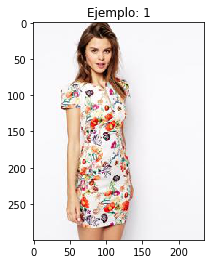

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


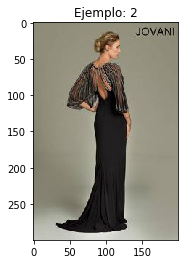

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'maxi_length', 'short_sleeve', 'solid']


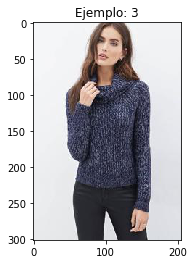

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


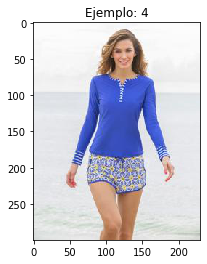

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


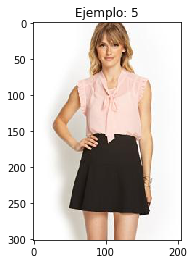

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'mini_length', 'no_neckline', 'sleeveless', 'solid']


In [54]:
y_pred_combined = res_split_models[0]
display_examples(y_pred_combined)

Mostramos también los resultados por cada atributo:

In [55]:
res_table_multiple = build_results_table(y_pred_combined)
res_table_multiple

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Recall,Precision,F1
0,floral,Estampado,664,664,421,243,0.63,0.63,0.63
1,graphic,Estampado,668,503,310,193,0.46,0.62,0.53
2,striped,Estampado,292,200,165,35,0.57,0.82,0.67
3,embroidered,Estampado,338,0,0,0,0.00,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00,0.00
5,solid,Estampado,1898,2516,1750,766,0.92,0.70,0.79
6,lattice,Estampado,62,1,1,0,0.02,1.00,0.03
7,long_sleeve,Tipo de manga,1243,1178,1044,134,0.84,0.89,0.86
8,short_sleeve,Tipo de manga,686,631,514,117,0.75,0.81,0.78
9,sleeveless,Tipo de manga,2071,2213,1927,286,0.93,0.87,0.90


Y los resultados por tipo de atributo

In [56]:
res_per_attr_type_split = build_results_table_by_attr_type(y_pred_combined)
res_per_attr_type_split

,Recall,Precision,F1
Tipo,,,
Estampado,0.37,0.54,0.38
Forma,0.71,0.79,0.74
Tallaje,0.47,0.54,0.48
Tejido,0.17,0.14,0.14
Tipo de cuello,0.51,0.50,0.50
Tipo de manga,0.84,0.86,0.85


A partir de la muestra de 5 imágenes con los atributos reales y predichos, se puede comprobar que esta versión aparentemente predice una mayor cantidad de etiquetas incorrectas en comparación a la primera versión. 

En cuanto a las tablas de resultados por atributo y tipo de atributo, reflejan los mismos problemas que ocurrían con la versión formada por un único clasificador. Por un lado, el la diferencia en la frecuencia de aparición de los atributos hace que el modelo tienda a ignorar los atributos minoritarios, y por otro lado, aprende mejor las características relativas a la forma que al material. 

Finalmente, vemos que el valor de F1 por tipo de atributo es, en general igual o superior al modelo formado por un único clasificador, salvo por el tipo de atributo *Tejido* donde es significativamente inferior, y que provoca que el F1 global sea inferior al otro modelo. 

# 8. Comparativa

Comparativa global:

In [57]:
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (res_split_models[1], 'Clasif. múltiple')] 

build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. múltiple,0.77,0.77,0.77,0.45,0.51,0.45


Comparativa por tipo de atributo:

In [58]:
pd.concat([res_per_attr_type_single, res_per_attr_type_split], axis=1, keys=['Clasif. único (VGG16)', 'Clasif. múltiple'])

Clasif. único (VGG16)                Clasif. múltiple  \
                              Recall Precision   F1           Recall   
Tipo                                                                   
Estampado                       0.37      0.51 0.38             0.37   
Forma                           0.76      0.78 0.77             0.71   
Tallaje                         0.39      0.54 0.39             0.47   
Tejido                          0.24      0.41 0.23             0.17   
Tipo de cuello                  0.48      0.49 0.48             0.51   
Tipo de manga                   0.79      0.79 0.79             0.84   

                               
               Precision   F1  
Tipo                           
Estampado           0.54 0.38  
Forma               0.79 0.74  
Tallaje             0.54 0.48  
Tejido              0.14 0.14  
Tipo de cuello      0.50 0.50  
Tipo de manga       0.86 0.85

Comparativa desglosada por atributo:

In [59]:
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_multiple[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Clasif. múltiple']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Clasif. múltiple                 
             Recall Precision   F1  
0              0.63      0.63 0.63  
1              0.46      0.62 0.53  
2              0.57      0.82 0.67  
3              0.00      0.00 0.00  
4              0.00      0.00 0.00  
5              0.92      0.70 0.79  
6              0.02      1.00 0.03  
7              0.84      0.89 0.86  
8              0.75      0.81 0.78  
9              0.93      0.87 0.90  
10             0.65      0.80 0.72  
11             0.52      0.72 0.61  
12             0.95      0.86 0.90  
13             0.63      0.75 0.68  
14             0.59      0.52 0.56  
15             0.00      0.00 0.00  
16             0.81      0.71 0.76  
17             0.00      0.00 0.00  
18             0.00      0.00 0.00  
19             1.00      0.68 0.81  
20             0.00      0.00 0.00  
21             0.00      0.00 0.00  
22             0.01      0.18 0.00  
23             0.42      0.76 0.54  
24             0.00      0.00 0.00  
25             0.98      0.85 0.91

Tal y como se ha mencionado en la sección de selección de métricas, para establecer la comparativa de qué modelo es mejor se empleará la métrica de F1 calculada con *macro-average* como métrica principal. Se considera que esta métrica es la que más se ajusta a un problema de clasificación multietiqueta con datos desbalanceados, puesto que otorga a todos los atributos el mismo peso dentro del cálculo. La versión de F1 calculada con *macro-average* da una estimación del rendimiento global del modelo pero ignora los atributos con poca representatividad en el set de datos, por lo que favorece a los clasificadores con un alto rendimiento en las etiquetas mayoritarias. 

Data esta métrica, se ha obtenido un valor superior para la versión de un único clasificador (0.46) frente al 0.45 obtenido por la versión compuesta por varios clasificadores. A partir del desglose por tipo de atributo se puede comprobar que, de los seis tipos de atributos, la versión formada por múltiples clasificadores es superior en tres de ellos, ligéramente inferior en dos, y significativamente inferior clasificando el *Tejido*. A partir de la última tabla se puede comprobar que esto se debe a que el modelo no identifica nunca los atributos *denim* y *chiffon* lo cual penaliza su F1 calculada con *macro-average*.

Tal como se ha comentado ya en los apartados de análisis de resultados de las dos versiones, así como en el notebook de [análisis de datos](./DeepFashion_VersionReducida_Analisis.ipynb), el principal problema para la clasificación de estos atributos, así como de otros como *square_neckline*, *leather* o *faux* es que su frecuencia de aparición en los datos es muy baja en comparación con otros atributos del mismo tipo y los modelos entrenados a partir de redes neuronales, por regla general, difícilmente llegan a aprender de forma correcta características de estos atributos minoritarios. 

Hay que tener en cuenta también que en la versión de un modelo por tipo de atributo se ha incorporado cierto conocimiento a priori a partir de la investigación del conjunto de datos, y es que siempre existe un único atributo por cada tipo, lo que ha permitido emplear clasificadores basados en categorical crossentropy y softmax. En el caso de haber empleado exáctamente los mismos parámetros en ambas versiones (binary crossentropy y sigmoid), los resultados podrían haber sido distintos. 

Finalmente, y como ya se ha remarcado anteriormente en apartados anteriores, al no haber incluido en los ningún tipo de landmarks ni bounding boxes, en las imágenes en las que aparecen varias prendas, es posible que las anotaciones se refieran a unas de ellas mientras que las etiquetas predichas por los modelos apliquen a otra, influyendo de forma negativa en los resultados de ambas versiones. 

# 9. Correción de Data Imbalance

En este apartado se intentará reducir el impacto del _data imbalance_ comentado en el apartado anterior. Para ello se probarán varias técnicas aplicadas a los dos modelos con mejor rendimiento obtenidos hasta este punto, y se establecerá una comparativa entre los modelos entrenados a partir de los datos originales y de los datos modificados. 

La construcción de los datasets modificados se encuentra en el apartado de _Data Imbalance_ del notebook de [análisis de datos](./DeepFashion_VersionReducida_Analisis.ipynb#Data-imbalance).

A continuación se define el código necesario para entrenar y evaluar un modelo a partir de los parámetros de otro modelo entrenado con anterioridad. 

In [60]:
# Entrena un modelo nuevo a partir de los resultados de la versión base de un modelo dado
def recompute(results,
              model_name,
              model_id,
              class_weight = None,
              output_layer_size = NUM_CLASSES, 
              activation_function = 'sigmoid', 
              loss_function = binary_crossentropy,
              attr_type = None):
    params = {}
    params[GLOBAL_POOLING_TYPE] = results['global_pooling_type']
    params[DENSE_LAYER_SIZE_PARAM] = results['dense_layer_size']
    freeze_layers_ratio = results['freeze_layers_ratio']
            
    # Definición de la función de activación para usar en la capa de salida
    params[ACTIVATION_FUNCTION] = activation_function
    params[OUTPUT_LAYER_SIZE] = output_layer_size
    
            
    # Llamada a la función de entrenamiento definida en apartados anteriores
    (val_loss,  val_acc, val_auc) = train(model_name, model_id, store_model=True, two_step_fit=True, 
                                          freeze_layers_ratio=freeze_layers_ratio, model_build_params=params, attr_type=attr_type, 
                                          loss_function=loss_function, class_weight=class_weight)
    
    return  (val_loss,  val_acc, val_auc)


# Entrena y evalua un modelo nuevo a partir de los resultados de la versión base de un modelo dado
def reevaluate(model_name,
               model_id,
               results_without_class_weights, 
               class_weight=None,
               attr_type=None):
    results = results_without_class_weights.iloc[0]
    results_with_class_weights = recompute(results, model_name, model_id, class_weight)
    return evaluate(model_name, model_id = model_id)

In [61]:
def recompute_split_model(results, model_id):
    # Recupera los mejores resultados para el modelo con clasificadores separados
    r = get_best_result_per_attribute_type(results)
    to_evaluate = []
    for attr_type in range(1,7):
        # Recupera los parámetros de la mejor versión
        res_for_attr_type = r[attr_type].sort_values(['max_val_acc', 'min_val_loss'], ascending=[False, True]).iloc[0]
        model_name = res_for_attr_type['architecture']
        activation_function = 'softmax'
        loss_function = categorical_crossentropy
        num_classes = len(attr_type_to_columns[str(attr_type)])
        
        # Recalcula el modelo
        recompute(res_for_attr_type, model_name, model_id, None, 
                  num_classes, activation_function, loss_function, attr_type)
        
        to_evaluate.append([attr_type, model_name, model_id])
    return evaluate_separate_models(to_evaluate)   

## 9.1 Class weight

Se asignarán pesos de forma inversamente proporcional al número de apariciones de una etiqueta dentro de la partición de entrenamiento. Supongamos, por ejemplo, una muestra de 20 observaciones donde la etiqueta A tiene valor positivo en 10 de ellas y la etiqueta B en 2 de ellas. Los pesos calculados serían:
* A: 20/10 = 2
* B: 20/2 = 10

El cálculo se realiza a partir de la partición de entrenamiento. Los valores se pasan como parámetro a la función *fit_generator* durante el entrenamiento del modelo. No ha sido necesaria la creación de una versión modificada de la partición de entrenamiento. 

In [62]:
# Calcula los pesos en base a la inversa de la proporción de la etiqueta con respecto al número de muestras del dataset
#Ejemplo: para una etiqueta con 20 ocurrencias en 4000 observaciones, el peso sería 200 (4000/20)
def compute_class_weights():
    partition_attribute_filepath = ANNO_FINE_PATH + "/train_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    attr_frequencies = y_true_df.sum().tolist()
    test_size = len(y_true_df)
    weights = [test_size/f for f in attr_frequencies]
    return weights

# Calcula los pesos de cada etiqueta y entrena y evalua un modelo nuevo
def reevaluate_with_class_weights(model_name,
                                  results_without_class_weights, 
                                  attr_type=None):
    class_weight = compute_class_weights()
    return reevaluate(model_name, 'class_weight', results_without_class_weights, class_weight, None)

In [63]:
#%cache -r vgg16_test_res_with_cw
%cache vgg16_test_res_with_cw = reevaluate_with_class_weights('VGG16', results_vgg16)

Loading cached value for variable 'vgg16_test_res_with_cw'. Time since caching: 13 days, 23:39:44.702620


Comparativa entre el modelo original y el alternativo:

In [64]:
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_with_cw[1], 'Clasif. único (VGG16) con pesos')]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) con pesos,0.73,0.73,0.73,0.40,0.54,0.40


In [65]:
res_table_single_with_cw = build_results_table(vgg16_test_res_with_cw[0])
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_single_with_cw[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Single classifier (VGG16) con pesos']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Single classifier (VGG16) con pesos                 
                                Recall Precision   F1  
0                                 0.59      0.65 0.62  
1                                 0.39      0.65 0.49  
2                                 0.46      0.91 0.61  
3                                 0.00      1.00 0.01  
4                                 0.00      0.00 0.00  
5                                 0.88      0.72 0.79  
6                                 0.00      0.00 0.00  
7                                 0.81      0.71 0.76  
8                                 0.33      0.79 0.47  
9                                 0.88      0.80 0.84  
10                                0.52      0.74 0.61  
11                                0.50      0.57 0.53  
12                                0.95      0.85 0.90  
13                                0.69      0.60 0.64  
14                                0.37      0.48 0.36  
15                                0.00      0.00 0.00  
16                                0.74      0.67 0.70  
17                                0.10      0.64 0.13  
18                                0.15      0.52 0.16  
19                                0.99      0.69 0.81  
20                                0.00      0.00 0.00  
21                                0.00      0.00 0.00  
22                                0.00      0.50 0.00  
23                                0.10      0.65 0.13  
24                                0.00      0.00 0.00  
25                                0.99      0.81 0.89

Como se puede comprobar en los resultados mostrados en las tablas anteriores, el rendimiento del modelo baja significativamente al aplicar los pesos por clase sobre el modelo de un único clasificador. Dados estos resultados, se obvia su cálculo para la versión compuesta por varios clasificadores. 

## 9.2 Oversampling y undersampling por etiqueta

En segundo lugar vamos a hacer oversampling de los atributos minoritarios y undersampling de los mayoritarios. Esto no es sencillo en el caso de clasificación multilabel puesto que ambos pueden aparecer asociados a una misma observación. Para ello se ha establecido un algoritmo de ranking, en el que a cada observación se le asigna una puntuación en función de la frecuencia de aparición de los atributos con valor positivo que la forman. 

El procedimiento que se seguirá en este caso es el siguiente:
- Se ordenarán los atributos de un mismo tipo de atributo en base al número de ocurrencias, y se le asignará un peso en base a la posición en esa ordenación. Por ejemplo, en el caso de tener las siguientes etiquetas con el siguiente número de observaciones: {A:10, B:40, C:20, D:60}, los pesos serían: {A:1/4, B:3/4, C:2/4, D:4/4} = {A:0.25, C:0.5, B:0.75, D:1}
- Se calcula la puntuación de las observaciones. La puntuación de una observación es la suma de la multiplicación de los atributos con 1s por su peso correspondiente.
- Para un 30% del dataset, de forma iterativa en batches de 200 elementos:
    - Se ordenan las observaciones por su peso. 
    - Se calcula el percentil 25 y 75 del peso de las observaciones
    - Se eliminan 200 elementos de forma aleatoria y ponderada en base al peso, de las observaciones cuyo peso es superior al p75.
    - Se duplican 200 elementos de forma aleatoria y ponderada en base al peso inverso, de las observaciones cuyo peso es inferior al p25. 
    
Siguiendo este procedimiento, en cada iteración se eliminan observaciones formadas por atributos mayoritarios y se duplican observaciones formadas por atributos minoritarios.  

In [66]:
# Sobreescribimos la función definida anteriormente para que a la hora de realizar el entrenamiento del modelo 
# emplee el fichero definido por la variable TRAIN_FILENAME en vez del fichero original.
def build_iterator_dataframe(partition, attr_type=None):
    if partition == 'train':
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + TRAIN_FILENAME
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', index_col=False, header=0)
    else:
        partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
        data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    
        if 'filename' not in data.columns:
            data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [67]:
TRAIN_FILENAME = "train_attr_v2.txt"

#%cache -r vgg16_test_res_with_sampling
%cache vgg16_test_res_with_sampling = reevaluate('VGG16', 'data_imbalance', results_vgg16)
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_with_sampling[1], 'Clasif. único (VGG16) con over/undersampling')]
build_result_df(result_list, k=6)

Loading cached value for variable 'vgg16_test_res_with_sampling'. Time since caching: 13 days, 23:31:01.064424


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) con over/undersampling,0.72,0.72,0.72,0.50,0.56,0.48


Resultados de la versión alternativa (clasificador único) por tipo de atributo:

In [68]:
build_results_table_by_attr_type(vgg16_test_res_with_sampling[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.48,0.60,0.49
Forma,0.75,0.70,0.73
Tallaje,0.47,0.48,0.42
Tejido,0.31,0.48,0.27
Tipo de cuello,0.46,0.48,0.45
Tipo de manga,0.79,0.73,0.75


Comparativa entre el modelo original y el alternativo para cada uno de los atributos:

In [69]:
res_table_single_with_sampling = build_results_table(vgg16_test_res_with_sampling[0])
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_single_with_sampling[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Clasif. único (VGG16) con over/undersampling']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Clasif. único (VGG16) con over/undersampling                 
                                         Recall Precision   F1  
0                                          0.56      0.68 0.61  
1                                          0.38      0.67 0.48  
2                                          0.70      0.74 0.72  
3                                          0.17      0.35 0.12  
4                                          0.35      0.34 0.23  
5                                          0.81      0.76 0.78  
6                                          0.35      0.65 0.46  
7                                          0.85      0.75 0.80  
8                                          0.74      0.54 0.62  
9                                          0.78      0.91 0.84  
10                                         0.73      0.63 0.67  
11                                         0.66      0.56 0.61  
12                                         0.87      0.92 0.89  
13                                         0.87      0.55 0.67  
14                                         0.45      0.56 0.50  
15                                         0.00      0.00 0.00  
16                                         0.52      0.79 0.63  
17                                         0.40      0.37 0.30  
18                                         0.32      0.39 0.26  
19                                         0.72      0.75 0.73  
20                                         0.00      0.00 0.00  
21                                         0.02      1.00 0.04  
22                                         0.38      0.35 0.27  
23                                         0.41      0.45 0.37  
24                                         0.05      0.15 0.02  
25                                         0.96      0.83 0.89

Con esta técnica se consigue aumentar el F1 con _macro-average_ en dos puntos. Se consigue que el atributo _lattice_ que se ignoraba en las predicciones del modelo original, obtenga un valor de F1 cercano a la media. El F1 de atributos minoritarios como _knit_ también incrementa, y se empieza a incluir en la predicción (aunque con muy baja precisión) otros atributos como _loose_ o _faux_ anteriormente ignorados. Por el contrario, el F1 de atributos mayoritarios disminuye y de ahí que se haya obtenido un valor inferior para el F1 con _micro-average_. 

Realizamos el mismo proceso para el modelo formado por un clasificador por tipo de atributo. 

In [70]:
%cache res_sampling_split_model = recompute_split_model(results_split_per_attr_type, 'data_imbalance')

result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_with_sampling[1], 'Clasif. único (VGG16) con over/undersampling'),
               (res_split_models[1], 'Clasif. múltiple'),
               (res_sampling_split_model[1], 'Clasif. múltiple con over/undersampling')
              ]
build_result_df(result_list, k=6)

Loading cached value for variable 'res_sampling_split_model'. Time since caching: 13 days, 20:14:45.633003


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) con over/undersampling,0.72,0.72,0.72,0.50,0.56,0.48
Clasif. múltiple,0.77,0.77,0.77,0.45,0.51,0.45
Clasif. múltiple con over/undersampling,0.76,0.76,0.76,0.54,0.54,0.51


A partir de la tabla anterior se observa que con este modelo es con el que se obtiene el valor de F1 con _macro-average_ más alto obtenido hasta el momento, manteniendo el valor de F1 con _micro-average_ entre los más altos. 

Resultados de la versión alternativa (clasificador múltiple) por tipo de atributo:

In [71]:
build_results_table_by_attr_type(res_sampling_split_model[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.52,0.60,0.52
Forma,0.83,0.76,0.79
Tallaje,0.53,0.47,0.50
Tejido,0.26,0.27,0.22
Tipo de cuello,0.50,0.50,0.48
Tipo de manga,0.87,0.84,0.86


A continuación se compara el clasificador múltiple original con la versión modificada en este apartado:

In [72]:
res_table_multi_with_sampling = build_results_table(res_sampling_split_model[0])
dfs = [res_table_multiple[["Atributo", "Tipo"]], 
       res_table_multiple[["Recall", "Precision", "F1"]],
       res_table_multi_with_sampling[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. múltiple', 'Clasif. múltiple con over/undersampling']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. múltiple                 \
           Atributo            Tipo           Recall Precision   F1   
0            floral       Estampado             0.63      0.63 0.63   
1           graphic       Estampado             0.46      0.62 0.53   
2           striped       Estampado             0.57      0.82 0.67   
3       embroidered       Estampado             0.00      0.00 0.00   
4           pleated       Estampado             0.00      0.00 0.00   
5             solid       Estampado             0.92      0.70 0.79   
6           lattice       Estampado             0.02      1.00 0.03   
7       long_sleeve   Tipo de manga             0.84      0.89 0.86   
8      short_sleeve   Tipo de manga             0.75      0.81 0.78   
9        sleeveless   Tipo de manga             0.93      0.87 0.90   
10      maxi_length           Forma             0.65      0.80 0.72   
11      mini_length           Forma             0.52      0.72 0.61   
12         no_dress           Forma             0.95      0.86 0.90   
13    crew_neckline  Tipo de cuello             0.63      0.75 0.68   
14       v_neckline  Tipo de cuello             0.59      0.52 0.56   
15  square_neckline  Tipo de cuello             0.00      0.00 0.00   
16      no_neckline  Tipo de cuello             0.81      0.71 0.76   
17            denim          Tejido             0.00      0.00 0.00   
18          chiffon          Tejido             0.00      0.00 0.00   
19           cotton          Tejido             1.00      0.68 0.81   
20          leather          Tejido             0.00      0.00 0.00   
21             faux          Tejido             0.00      0.00 0.00   
22             knit          Tejido             0.01      0.18 0.00   
23            tight         Tallaje             0.42      0.76 0.54   
24            loose         Tallaje             0.00      0.00 0.00   
25     conventional         Tallaje             0.98      0.85 0.91   

   Clasif. múltiple con over/undersampling                 
                                    Recall Precision   F1  
0                                     0.54      0.68 0.60  
1                                     0.44      0.59 0.51  
2                                     0.75      0.70 0.72  
3                                     0.24      0.38 0.19  
4                                     0.36      0.39 0.28  
5                                     0.83      0.78 0.80  
6                                     0.50      0.66 0.57  
7                                     0.90      0.86 0.88  
8                                     0.83      0.75 0.79  
9                                     0.89      0.93 0.91  
10                                    0.84      0.68 0.75  
11                                    0.75      0.68 0.71  
12                                    0.90      0.93 0.91  
13                                    0.81      0.62 0.70  
14                                    0.68      0.47 0.56  
15                                    0.00      0.00 0.00  
16                                    0.53      0.89 0.67  
17                                    0.64      0.39 0.49  
18                                    0.00      0.50 0.00  
19                                    0.93      0.71 0.80  
20                                    0.00      0.00 0.00  
21                                    0.00      0.00 0.00  
22                                    0.00      0.00 0.00  
23                                    0.67      0.55 0.60  
24                                    0.00      0.00 0.00  
25                                    0.92      0.87 0.89

Comparamos también ambas versiones modificadas:

In [73]:
res_table_multi_with_sampling = build_results_table(res_sampling_split_model[0])
dfs = [res_table_single_with_sampling[["Atributo", "Tipo"]], 
       res_table_single_with_sampling[["Recall", "Precision", "F1"]],
       res_table_multi_with_sampling[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16) con over/undersampling', 'Clasif. múltiple con over/undersampling']
pd.concat(dfs, axis=1, keys=keys)

Atributos                  \
           Atributo            Tipo   
0            floral       Estampado   
1           graphic       Estampado   
2           striped       Estampado   
3       embroidered       Estampado   
4           pleated       Estampado   
5             solid       Estampado   
6           lattice       Estampado   
7       long_sleeve   Tipo de manga   
8      short_sleeve   Tipo de manga   
9        sleeveless   Tipo de manga   
10      maxi_length           Forma   
11      mini_length           Forma   
12         no_dress           Forma   
13    crew_neckline  Tipo de cuello   
14       v_neckline  Tipo de cuello   
15  square_neckline  Tipo de cuello   
16      no_neckline  Tipo de cuello   
17            denim          Tejido   
18          chiffon          Tejido   
19           cotton          Tejido   
20          leather          Tejido   
21             faux          Tejido   
22             knit          Tejido   
23            tight         Tallaje   
24            loose         Tallaje   
25     conventional         Tallaje   

   Clasif. único (VGG16) con over/undersampling                 \
                                         Recall Precision   F1   
0                                          0.56      0.68 0.61   
1                                          0.38      0.67 0.48   
2                                          0.70      0.74 0.72   
3                                          0.17      0.35 0.12   
4                                          0.35      0.34 0.23   
5                                          0.81      0.76 0.78   
6                                          0.35      0.65 0.46   
7                                          0.85      0.75 0.80   
8                                          0.74      0.54 0.62   
9                                          0.78      0.91 0.84   
10                                         0.73      0.63 0.67   
11                                         0.66      0.56 0.61   
12                                         0.87      0.92 0.89   
13                                         0.87      0.55 0.67   
14                                         0.45      0.56 0.50   
15                                         0.00      0.00 0.00   
16                                         0.52      0.79 0.63   
17                                         0.40      0.37 0.30   
18                                         0.32      0.39 0.26   
19                                         0.72      0.75 0.73   
20                                         0.00      0.00 0.00   
21                                         0.02      1.00 0.04   
22                                         0.38      0.35 0.27   
23                                         0.41      0.45 0.37   
24                                         0.05      0.15 0.02   
25                                         0.96      0.83 0.89   

   Clasif. múltiple con over/undersampling                 
                                    Recall Precision   F1  
0                                     0.54      0.68 0.60  
1                                     0.44      0.59 0.51  
2                                     0.75      0.70 0.72  
3                                     0.24      0.38 0.19  
4                                     0.36      0.39 0.28  
5                                     0.83      0.78 0.80  
6                                     0.50      0.66 0.57  
7                                     0.90      0.86 0.88  
8                                     0.83      0.75 0.79  
9                                     0.89      0.93 0.91  
10                                    0.84      0.68 0.75  
11                                    0.75      0.68 0.71  
12                                    0.90      0.93 0.91  
13                                    0.81      0.62 0.70  
14                                    0.68      0.47 0.56  
15                                    0.00      

La mejora de la versión generada en este apartado frente al modelo formado por múltiples clasificadores original se debe a que con la modificación del conjunto de datos se ha conseguido que 4 atributos que anteriormente no formaban parte de las predicciones (*embroidered*, *pleated*, *denim*, *chiffon*) ahora sí formen parte de las predicciones. 

En la comparativa entre las dos versiones creadas en este apartado se observa que la versión de un único clasificador predice al menos una vez 24 de los 26 atributos, mientras que la versión compuesta predice únicamente 20 de ellos. Sin embargo, la segunda versión tiene una precisón y una exhaustividad superior. 

## 9.3 Una observación por combinación de etiquetas

Esta técnica se basa en el problema de [One-shot learning](https://en.wikipedia.org/wiki/One-shot_learning) de visión por computador en el que el modelo se entrena a partir de observaciones únicas. Aplicado al problema actual, se entrenará el modelo a partir de combinaciones de atributos únicas.  Para ello, se va a descartar combinaciones duplicadas y con ello, como se muestra en el [notebook de análisis adjunto](./DeepFashion_VersionReducida_Analisis.ipynb#Opcion-3:-Una-observación-por-combinación-de-etiquetas), se reduce en un orden de magnitud la diferencia entre la frecuencia de aparición de los atributos minoritarios y mayoritarios. También se reduce de forma significativa el volumen de datos sobre el que se realiza el entrenamiento: el número de observaciones se reduce de 14000 a 905.

In [74]:
TRAIN_FILENAME = "train_attr_v3.txt"
#%cache -r vgg16_test_res_with_os
%cache vgg16_test_res_with_os = reevaluate('VGG16', 'data_imbalance_n1', results_vgg16)
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_with_os[1], 'Clasif. único (VGG16) N=1')]
build_result_df(result_list, k=6)

Loading cached value for variable 'vgg16_test_res_with_os'. Time since caching: 13 days, 22:40:22.481610


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) N=1,0.66,0.66,0.66,0.50,0.50,0.45


Resultados de la versión alternativa (clasificador único) por tipo de atributo:

In [75]:
build_results_table_by_attr_type(vgg16_test_res_with_os[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.47,0.54,0.45
Forma,0.81,0.69,0.74
Tallaje,0.60,0.46,0.47
Tejido,0.28,0.31,0.20
Tipo de cuello,0.43,0.42,0.42
Tipo de manga,0.75,0.70,0.72


Comparamos el modelo original con la variante constuída en este apartado:

In [76]:
res_table_single_with_n1 = build_results_table(vgg16_test_res_with_os[0])
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_single_with_n1[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Clasif. único (VGG16) N=1']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Clasif. único (VGG16) N=1                 
                      Recall Precision   F1  
0                       0.56      0.66 0.60  
1                       0.38      0.55 0.42  
2                       0.66      0.63 0.64  
3                       0.23      0.25 0.12  
4                       0.45      0.29 0.26  
5                       0.66      0.81 0.73  
6                       0.34      0.55 0.37  
7                       0.83      0.72 0.77  
8                       0.61      0.54 0.57  
9                       0.80      0.85 0.82  
10                      0.82      0.62 0.71  
11                      0.76      0.53 0.63  
12                      0.85      0.93 0.89  
13                      0.67      0.57 0.62  
14                      0.49      0.47 0.46  
15                      0.00      0.00 0.00  
16                      0.55      0.64 0.59  
17                      0.19      0.41 0.16  
18                      0.53      0.24 0.26  
19                      0.54      0.75 0.63  
20                      0.04      0.07 0.01  
21                      0.02      0.17 0.01  
22                      0.34      0.22 0.15  
23                      0.63      0.40 0.49  
24                      0.40      0.13 0.10  
25                      0.76      0.86 0.81

Como se puede apreciar en los resultados, con esta variante todos los atributos a excepción de _square_neckline_ (atributo con menor representatividad en el set) están incluídos en alguna de las predicciones. Sin embargo, el valor de F1 obtenido para estos atributos es muy pequeño. 

Nótese también que a pesar de que el valor de F1 con _macro-average_ es prácticamente igual que el del modelo original (se incrementa el rendimiento de los atributos minoritarios a costa de los mayoritarios), el valor de F1 con _micro-average_ se reduce en 10 puntos al verse reducido el rendimiento en la clasificación de los atributos mayoritarios. Por ello, se considera que el rendimiento de esta variante es inferior al modelo original y se obvia su aplicación al modelo formado por múltiples clasificadores. 

## 9.4 N observaciones por combinaciones de etiquetas sin oversampling

Esta alternativa es un variante de la opción 3, en la que se permite un máximo de N observaciones con una misma combinación de atributos. La distribución de las combinaciones de atributos se analiza en el [notebook adjunto](./DeepFashion_VersionReducida_Analisis.ipynb#Opci%C3%B3n-4:-N-observaciones-por-combinaciones-de-etiquetas-sin-oversampling).
En dicho notebook se observa que la media de número de observaciones por combinación es de 15 y la mediana de 3. Por ello, en este apartado se probará con un máximo de 3, 5, 10 y 15 observaciones de una misma combinación de atributos. En el caso de que una combinación no llegue a dicho número máximo, no se realiza oversampling para llegar a este valor máximo. 

In [77]:
RESET = False
if RESET:
    %cache -r vgg16_test_res_n3
    %cache -r vgg16_test_res_n5
    %cache -r vgg16_test_res_n10
    %cache -r vgg16_test_res_n15      

TRAIN_FILENAME = "train_attr_v4_3.txt"
%cache vgg16_test_res_n3 = reevaluate('VGG16', 'data_imbalance_n3', results_vgg16)
TRAIN_FILENAME = "train_attr_v4_5.txt"
%cache vgg16_test_res_n5 = reevaluate('VGG16', 'data_imbalance_n5', results_vgg16)
TRAIN_FILENAME = "train_attr_v4_10.txt"
%cache vgg16_test_res_n10 = reevaluate('VGG16', 'data_imbalance_n10', results_vgg16)
TRAIN_FILENAME = "train_attr_v4_15.txt"
%cache vgg16_test_res_n15 = reevaluate('VGG16', 'data_imbalance_n15', results_vgg16)

Loading cached value for variable 'vgg16_test_res_n3'. Time since caching: 14 days, 5:45:46.019505
Loading cached value for variable 'vgg16_test_res_n5'. Time since caching: 14 days, 5:37:48.159955
Loading cached value for variable 'vgg16_test_res_n10'. Time since caching: 14 days, 5:29:27.178743
Loading cached value for variable 'vgg16_test_res_n15'. Time since caching: 14 days, 5:20:09.006648


Comparamos el modelo original (único clasificador) con las cuatro variantes entrenadas en el paso anterior:

In [78]:
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_n3[1], 'Clasif. único (VGG16) N=3'),
               (vgg16_test_res_n5[1], 'Clasif. único (VGG16) N=5'),
               (vgg16_test_res_n10[1], 'Clasif. único (VGG16) N=10'),     
               (vgg16_test_res_n15[1], 'Clasif. único (VGG16) N=15'),                 
              ]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) N=3,0.70,0.70,0.70,0.49,0.53,0.46
Clasif. único (VGG16) N=5,0.72,0.72,0.72,0.50,0.53,0.48
Clasif. único (VGG16) N=10,0.66,0.66,0.66,0.48,0.51,0.43
Clasif. único (VGG16) N=15,0.65,0.65,0.65,0.47,0.49,0.42


Mostramos los resultados por tipo de atributo para el modelo con el que se obtienen mejores resultados (N=5).

In [79]:
build_results_table_by_attr_type(vgg16_test_res_n5[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.45,0.60,0.47
Forma,0.81,0.73,0.77
Tallaje,0.54,0.46,0.46
Tejido,0.28,0.33,0.25
Tipo de cuello,0.48,0.44,0.46
Tipo de manga,0.74,0.73,0.73


Comparativa por atributo entre el modelo original (único clasificador) y la variante construída en este apartado:

In [80]:
res_table_single_with_n5 = build_results_table(vgg16_test_res_n5[0])
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_single_with_n5[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Clasif. único (VGG16) N=5']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Clasif. único (VGG16) N=5                 
                      Recall Precision   F1  
0                       0.57      0.65 0.61  
1                       0.26      0.58 0.30  
2                       0.71      0.74 0.72  
3                       0.16      0.41 0.13  
4                       0.41      0.40 0.32  
5                       0.71      0.83 0.76  
6                       0.37      0.56 0.42  
7                       0.85      0.69 0.76  
8                       0.57      0.61 0.59  
9                       0.80      0.89 0.84  
10                      0.80      0.65 0.72  
11                      0.77      0.61 0.68  
12                      0.87      0.93 0.90  
13                      0.72      0.60 0.66  
14                      0.51      0.50 0.51  
15                      0.00      0.00 0.00  
16                      0.67      0.66 0.67  
17                      0.32      0.57 0.36  
18                      0.41      0.32 0.27  
19                      0.79      0.74 0.76  
20                      0.00      0.00 0.00  
21                      0.00      0.00 0.00  
22                      0.16      0.35 0.11  
23                      0.61      0.41 0.49  
24                      0.11      0.13 0.03  
25                      0.92      0.84 0.88

A partir de los resultados anteriores se observa que, al igual que con la segunda solución, se ha conseguido generar un modelo que incrementa el F1 de los atributos minoritarios a costa de disminuir el de los atributos mayoritarios. 

Vamos a volver a entrenar el modelo formado por un clasificador por tipo de atributo con esta modificación del dataset de entrenamiento. 

In [81]:
%cache res_sampling_split_model_n5 = recompute_split_model(results_split_per_attr_type, 'data_imbalance_n5')

result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_n5[1], 'Clasif. único (VGG16) N=5'),
               (res_split_models[1], 'Clasif. múltiple'),
               (res_sampling_split_model_n5[1], 'Clasif. múltiple N=5')
              ]
build_result_df(result_list, k=6)

Loading cached value for variable 'res_sampling_split_model_n5'. Time since caching: 13 days, 19:08:26.744392


,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) N=5,0.72,0.72,0.72,0.50,0.53,0.48
Clasif. múltiple,0.77,0.77,0.77,0.45,0.51,0.45
Clasif. múltiple N=5,0.72,0.72,0.72,0.50,0.47,0.46


Esta versión del clasificador múltiple mejora el rendimiento de la versión multi-clasificador original, pero tiene un rendimiento peor que la versión de un único clasificador creada a partir del mismo dataset modificado. 

Mostramos a continuación los resultados por tipo de atributo de esta versión alternativa.

In [82]:
build_results_table_by_attr_type(res_sampling_split_model_n5[0])

,Recall,Precision,F1
Tipo,,,
Estampado,0.51,0.50,0.45
Forma,0.81,0.67,0.72
Tallaje,0.57,0.51,0.50
Tejido,0.16,0.18,0.14
Tipo de cuello,0.45,0.45,0.44
Tipo de manga,0.84,0.80,0.82


A continuación se muestra la comparativa entre la versión original y la entrenada a partir del dataset modificado:

In [83]:
res_table_multiple_with_n5 = build_results_table(res_sampling_split_model_n5[0])

dfs = [res_table_multiple[["Atributo", "Tipo"]], 
       res_table_multiple[["Recall", "Precision", "F1"]],
       res_table_multiple_with_n5[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. múltiple', 'Clasif. múltiple N=5']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. múltiple                 \
           Atributo            Tipo           Recall Precision   F1   
0            floral       Estampado             0.63      0.63 0.63   
1           graphic       Estampado             0.46      0.62 0.53   
2           striped       Estampado             0.57      0.82 0.67   
3       embroidered       Estampado             0.00      0.00 0.00   
4           pleated       Estampado             0.00      0.00 0.00   
5             solid       Estampado             0.92      0.70 0.79   
6           lattice       Estampado             0.02      1.00 0.03   
7       long_sleeve   Tipo de manga             0.84      0.89 0.86   
8      short_sleeve   Tipo de manga             0.75      0.81 0.78   
9        sleeveless   Tipo de manga             0.93      0.87 0.90   
10      maxi_length           Forma             0.65      0.80 0.72   
11      mini_length           Forma             0.52      0.72 0.61   
12         no_dress           Forma             0.95      0.86 0.90   
13    crew_neckline  Tipo de cuello             0.63      0.75 0.68   
14       v_neckline  Tipo de cuello             0.59      0.52 0.56   
15  square_neckline  Tipo de cuello             0.00      0.00 0.00   
16      no_neckline  Tipo de cuello             0.81      0.71 0.76   
17            denim          Tejido             0.00      0.00 0.00   
18          chiffon          Tejido             0.00      0.00 0.00   
19           cotton          Tejido             1.00      0.68 0.81   
20          leather          Tejido             0.00      0.00 0.00   
21             faux          Tejido             0.00      0.00 0.00   
22             knit          Tejido             0.01      0.18 0.00   
23            tight         Tallaje             0.42      0.76 0.54   
24            loose         Tallaje             0.00      0.00 0.00   
25     conventional         Tallaje             0.98      0.85 0.91   

   Clasif. múltiple N=5                 
                 Recall Precision   F1  
0                  0.58      0.60 0.59  
1                  0.39      0.55 0.43  
2                  0.75      0.53 0.62  
3                  0.32      0.29 0.19  
4                  0.40      0.28 0.22  
5                  0.69      0.82 0.75  
6                  0.45      0.41 0.37  
7                  0.86      0.82 0.84  
8                  0.79      0.69 0.73  
9                  0.87      0.89 0.88  
10                 0.87      0.50 0.63  
11                 0.76      0.57 0.65  
12                 0.80      0.94 0.87  
13                 0.72      0.56 0.63  
14                 0.52      0.53 0.53  
15                 0.00      0.00 0.00  
16                 0.55      0.71 0.62  
17                 0.00      0.00 0.00  
18                 0.09      0.17 0.03  
19                 0.88      0.72 0.79  
20                 0.00      0.00 0.00  
21                 0.00      0.00 0.00  
22                 0.01      0.20 0.00  
23                 0.52      0.53 0.53  
24                 0.26      0.15 0.08  
25                 0.91      0.85 0.88

Comparativa entre los dos modelos entrenados en este apartado:

In [84]:
dfs = [res_table_single_with_n5[["Atributo", "Tipo"]], 
       res_table_single_with_n5[["Recall", "Precision", "F1"]],
       res_table_multiple_with_n5[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16) N=5', 'Clasif. múltiple N=5']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16) N=5                 \
           Atributo            Tipo                    Recall Precision   F1   
0            floral       Estampado                      0.57      0.65 0.61   
1           graphic       Estampado                      0.26      0.58 0.30   
2           striped       Estampado                      0.71      0.74 0.72   
3       embroidered       Estampado                      0.16      0.41 0.13   
4           pleated       Estampado                      0.41      0.40 0.32   
5             solid       Estampado                      0.71      0.83 0.76   
6           lattice       Estampado                      0.37      0.56 0.42   
7       long_sleeve   Tipo de manga                      0.85      0.69 0.76   
8      short_sleeve   Tipo de manga                      0.57      0.61 0.59   
9        sleeveless   Tipo de manga                      0.80      0.89 0.84   
10      maxi_length           Forma                      0.80      0.65 0.72   
11      mini_length           Forma                      0.77      0.61 0.68   
12         no_dress           Forma                      0.87      0.93 0.90   
13    crew_neckline  Tipo de cuello                      0.72      0.60 0.66   
14       v_neckline  Tipo de cuello                      0.51      0.50 0.51   
15  square_neckline  Tipo de cuello                      0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                      0.67      0.66 0.67   
17            denim          Tejido                      0.32      0.57 0.36   
18          chiffon          Tejido                      0.41      0.32 0.27   
19           cotton          Tejido                      0.79      0.74 0.76   
20          leather          Tejido                      0.00      0.00 0.00   
21             faux          Tejido                      0.00      0.00 0.00   
22             knit          Tejido                      0.16      0.35 0.11   
23            tight         Tallaje                      0.61      0.41 0.49   
24            loose         Tallaje                      0.11      0.13 0.03   
25     conventional         Tallaje                      0.92      0.84 0.88   

   Clasif. múltiple N=5                 
                 Recall Precision   F1  
0                  0.58      0.60 0.59  
1                  0.39      0.55 0.43  
2                  0.75      0.53 0.62  
3                  0.32      0.29 0.19  
4                  0.40      0.28 0.22  
5                  0.69      0.82 0.75  
6                  0.45      0.41 0.37  
7                  0.86      0.82 0.84  
8                  0.79      0.69 0.73  
9                  0.87      0.89 0.88  
10                 0.87      0.50 0.63  
11                 0.76      0.57 0.65  
12                 0.80      0.94 0.87  
13                 0.72      0.56 0.63  
14                 0.52      0.53 0.53  
15                 0.00      0.00 0.00  
16                 0.55      0.71 0.62  
17                 0.00      0.00 0.00  
18                 0.09      0.17 0.03  
19                 0.88      0.72 0.79  
20                 0.00      0.00 0.00  
21                 0.00      0.00 0.00  
22                 0.01      0.20 0.00  
23                 0.52      0.53 0.53  
24                 0.26      0.15 0.08  
25                 0.91      0.85 0.88

## 9.5 N observaciones por combinación de etiquetas con oversampling

Esta opción es una variante del apartado anterior en las que se permite como máximo N observaciones con la misma combinación de atributos, y en las que se hace oversampling de las combinaciones con un número de observaciones inferior. Este oversampling se realiza duplicando alguna de las observaciones existentes con la misma combinación de atributos. 

Como resultado, con esta técnica se consigue que todas las combinaciones de atributos presentes en el dataset original con el que se entrena el modelo tengan el mismo número de observaciones asociadas en la partición de entrenamiento. 

In [85]:
RESET = False
if RESET:
    %cache -r vgg16_test_res_n3_upsampling
    %cache -r vgg16_test_res_n5_upsampling
    %cache -r vgg16_test_res_n10_upsampling
    %cache -r vgg16_test_res_n15_upsampling      

TRAIN_FILENAME = "train_attr_v5_3.txt"
%cache vgg16_test_res_n3_upsampling = reevaluate('VGG16', 'data_imbalance_n3_us', results_vgg16)
TRAIN_FILENAME = "train_attr_v5_5.txt"
%cache vgg16_test_res_n5_upsampling = reevaluate('VGG16', 'data_imbalance_n5_us', results_vgg16)
TRAIN_FILENAME = "train_attr_v5_10.txt"
%cache vgg16_test_res_n10_upsampling = reevaluate('VGG16', 'data_imbalance_n10_us', results_vgg16)
TRAIN_FILENAME = "train_attr_v5_15.txt"
%cache vgg16_test_res_n15_upsampling = reevaluate('VGG16', 'data_imbalance_n15_us', results_vgg16)


Loading cached value for variable 'vgg16_test_res_n3_upsampling'. Time since caching: 14 days, 5:11:35.969780
Loading cached value for variable 'vgg16_test_res_n5_upsampling'. Time since caching: 14 days, 5:04:37.562648
Loading cached value for variable 'vgg16_test_res_n10_upsampling'. Time since caching: 14 days, 4:57:44.947260
Loading cached value for variable 'vgg16_test_res_n15_upsampling'. Time since caching: 14 days, 4:50:23.606884


In [86]:
result_list = [(vgg16_test_res[1], 'Clasif. único (VGG16)'),
               (vgg16_test_res_n3_upsampling[1], 'Clasif. único (VGG16) N=3 con over/undersampling'),
               (vgg16_test_res_n5_upsampling[1], 'Clasif. único (VGG16) N=5 con over/undersampling'),
               (vgg16_test_res_n10_upsampling[1], 'Clasif. único (VGG16) N=10 con over/undersampling'),     
               (vgg16_test_res_n15_upsampling[1], 'Clasif. único (VGG16) N=15 con over/undersampling'),                 
              ]
build_result_df(result_list, k=6)

,recall.micro,precision.micro,f1.micro,recall.macro,precision.macro,f1.macro
Clasif. único (VGG16),0.76,0.76,0.76,0.45,0.55,0.46
Clasif. único (VGG16) N=3 con over/undersampling,0.66,0.66,0.66,0.49,0.52,0.44
Clasif. único (VGG16) N=5 con over/undersampling,0.65,0.65,0.65,0.50,0.48,0.44
Clasif. único (VGG16) N=10 con over/undersampling,0.65,0.65,0.65,0.48,0.48,0.43
Clasif. único (VGG16) N=15 con over/undersampling,0.65,0.65,0.65,0.49,0.48,0.43


In [87]:
res_table_single_with_n3_os = build_results_table(vgg16_test_res_n3_upsampling[0])
dfs = [res_table_single[["Atributo", "Tipo"]], 
       res_table_single[["Recall", "Precision", "F1"]],
       res_table_single_with_n3_os[["Recall", "Precision", "F1"]]]
keys = keys=['Atributos', 'Clasif. único (VGG16)', 'Clasif. único (VGG16) N=3 con over/undersampling']
pd.concat(dfs, axis=1, keys=keys)

Atributos                 Clasif. único (VGG16)                 \
           Atributo            Tipo                Recall Precision   F1   
0            floral       Estampado                  0.67      0.63 0.65   
1           graphic       Estampado                  0.38      0.65 0.48   
2           striped       Estampado                  0.64      0.79 0.71   
3       embroidered       Estampado                  0.04      0.48 0.04   
4           pleated       Estampado                  0.01      0.25 0.01   
5             solid       Estampado                  0.87      0.76 0.81   
6           lattice       Estampado                  0.00      0.00 0.00   
7       long_sleeve   Tipo de manga                  0.84      0.79 0.81   
8      short_sleeve   Tipo de manga                  0.65      0.72 0.68   
9        sleeveless   Tipo de manga                  0.88      0.87 0.88   
10      maxi_length           Forma                  0.64      0.78 0.70   
11      mini_length           Forma                  0.72      0.65 0.68   
12         no_dress           Forma                  0.93      0.90 0.91   
13    crew_neckline  Tipo de cuello                  0.78      0.64 0.71   
14       v_neckline  Tipo de cuello                  0.44      0.55 0.48   
15  square_neckline  Tipo de cuello                  0.00      0.00 0.00   
16      no_neckline  Tipo de cuello                  0.71      0.75 0.73   
17            denim          Tejido                  0.20      0.70 0.29   
18          chiffon          Tejido                  0.21      0.49 0.20   
19           cotton          Tejido                  0.98      0.70 0.82   
20          leather          Tejido                  0.00      0.00 0.00   
21             faux          Tejido                  0.00      0.00 0.00   
22             knit          Tejido                  0.07      0.56 0.08   
23            tight         Tallaje                  0.17      0.80 0.28   
24            loose         Tallaje                  0.00      0.00 0.00   
25     conventional         Tallaje                  1.00      0.81 0.90   

   Clasif. único (VGG16) N=3 con over/undersampling                 
                                             Recall Precision   F1  
0                                              0.55      0.60 0.58  
1                                              0.24      0.56 0.27  
2                                              0.62      0.69 0.66  
3                                              0.18      0.31 0.11  
4                                              0.40      0.36 0.29  
5                                              0.70      0.80 0.75  
6                                              0.37      0.44 0.33  
7                                              0.85      0.66 0.75  
8                                              0.58      0.52 0.55  
9                                              0.74      0.86 0.80  
10                                             0.81      0.56 0.66  
11                                             0.79      0.48 0.60  
12                                             0.80      0.94 0.87  
13                                             0.66      0.57 0.61  
14                                             0.55      0.44 0.48  
15                                             0.00      0.00 0.00  
16                                             0.49      0.68 0.57  
17                                             0.10      0.40 0.08  
18                                             0.45      0.25 0.23  
19                                             0.68      0.74 0.71  
20                                             0.01      0.50 0.01  
21                                             0.04      0.40 0.03  
22                                             0.29      0.26 0.16  
23                                             0.64      0.36 0.46  
24                                             0.34      0.14 0.10  
25                

No se consigue mejorar los resultados del modelo original por lo que se obvia su aplicación para el modelo formado por múltiples clasificadores. 

# 10. Resumen y conclusiones

En este notebook se han explorado distintas alternativas para la clasificación multietiqueta de imágenes de moda a partir de la versión reducida del dataset DeepFashion, tanto para modelos formados por un clasificador único para todos los tipos de atributo como para modelos compuestos por un clasificador por tipo de atributo. 

A partir de los datos originales y empleando F1 con *macro-average* como métrica de referencia principal, se ha obtenido un valor ligéramente superior para la versión formada por un único clasificador entrenado a partir de la arquitectura VGG16. Sin embargo, la versión formada por múltiples clasificadores obtenía resultados superiores en la mitad de los tipos de atributos, siendo penalizada por la clasificación del tipo de atributo *'Tejido'* donde el modelo formado por un único clasificador era significativamente mejor. Para ambos tipos de modelo se obtienen resultados superiores para los tipos de atributo relativos a la forma de la prenda (*Tallaje*, *Forma*, *Tipo de cuello*, *Tipo de manga*) que a los relativos al material (*Tejido*, *Estampado*). 

El principal problema detectado en la evaluación de resultados es que ambas variantes ignoraban en las predicciones los atributos cuya frecuencia de aparición en las tres particiones del dataset era uno o dos órdenes de magnitud inferior a otros atributos del mismo tipo. Para tratar de minimizar el impacto de este problema se ha aplicado cinco tecnicas con las que se ha modificado el dataset de entrenamiento. Aplicando dos de estas técnicas no se ha conseguido mejorar los resultados originales, y con dos de ellas se ha mejorado el rendimiento en la clasificación de atributos minoritarios a costa de reducir el rendimiento de clasificación de los atributos minoritarios. Únicamente la técnica de reemplazo de observaciones con conjuntos de atributos mayoritarios por observaciones con atributos minoritarios ([apartado 9.2](./DeepFashion_VersionReducida_Analisis.ipynb#9.2-Oversampling-y-undersampling-por-etiqueta)) mejora la clasificación de atributos minoritarios y mayoritarios. Con esta técnica, el rendimiento del modelo formado por múltiples clasificadores es superior al de un único clasificador. Sin embargo, se observa que en las predicciones se siguen ignorando ciertos atributos minoritarios. 

Una posible solución a este problema sería la adquisición de nuevos datos, por lo que ésta podría ser una futura extensión de este trabajo. Se ha descartado realizarlo como parte de este trabajo puesto que el análisis de la versión completa del conjunto de datos muestra que esta versión presenta el mismo problema y, puesto que se desea establecer una comparativa con los modelos considerados estado del arte de forma rigurosa, será necesario trabajar con los datos originales o un subconjunto de estos.  

No se ha realizado la comparativa con otros modelos en este apartado puesto que el benchmark de DeepFashion se basa en la versión completa del conjunto de datos. 